In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# ToolNode 

- LangGraph에서 pre-built
- 메시지 목록이 포함된 그래프 상태를 입력으로 받아 도구 호출 결과로 상태를 업데이트 

[참고] 
- PythonAstREPLTool
- LangChain에서 LLM이 파이썬 코드를 안전하게 실행할 수 있도록 만들어진 도구 
- AST(Abstract Syntax Tree) 기반으로 코드를 분석하고 실행하여, 더 안전하고 유연한 실행 환경 제공 

In [4]:
from typing import List, Dict
from langchain_core.tools import tool
# from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_teddynote.tools import GoogleNews
from langgraph.prebuilt import ToolNode, tools_condition

In [5]:
# PythonREPLTool import 오류 해결을 위한 대안 방법들
try:
    from langchain_experimental.tools import PythonREPLTool
    print("PythonREPLTool imported successfully")
except Exception as e:
    print(f"PythonREPLTool import failed: {e}")
    print("Trying alternative import methods...")
    
    # 대안 1: langchain_community에서 import 시도
    try:
        from langchain_community.tools import PythonREPLTool
        print("PythonREPLTool imported from langchain_community")
    except Exception as e2:
        print(f"langchain_community import failed: {e2}")
        
        # 대안 2: 직접 구현
        print("Creating custom PythonREPLTool...")
        from langchain_core.tools import BaseTool
        from typing import Any, Dict
        import subprocess
        import sys
        
        class PythonREPLTool(BaseTool):
            name: str = "python_repl"
            description: str = "A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`."
            
            def _run(self, query: str) -> str:
                """Use the tool."""
                try:
                    # Create a subprocess to run Python code
                    result = subprocess.run(
                        [sys.executable, "-c", query],
                        capture_output=True,
                        text=True,
                        timeout=30
                    )
                    if result.returncode != 0:
                        return f"Error: {result.stderr}"
                    return result.stdout
                except subprocess.TimeoutExpired:
                    return "Error: Code execution timed out"
                except Exception as e:
                    return f"Error: {str(e)}"
        
        print("Custom PythonREPLTool created successfully")

PythonREPLTool import failed: cannot pickle 'classmethod' object
Trying alternative import methods...
langchain_community import failed: cannot import name 'PythonREPLTool' from 'langchain_community.tools' (/Users/a05131/Library/Caches/pypoetry/virtualenvs/langchain-kr-t0JhnSEV-py3.11/lib/python3.11/site-packages/langchain_community/tools/__init__.py)
Creating custom PythonREPLTool...
Custom PythonREPLTool created successfully


### 도구 정의 

In [6]:
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

In [7]:
# 도구 리스트 생성
tools = [search_news, python_code_interpreter]

# ToolNode 정의 
tool_node = ToolNode(tools)

### 수동 호출

In [8]:
from langchain_core.messages import AIMessage

# 단일 도구 호출을 포함하는 AI 메시지 객체 생성
# AIMessage 객체이어야 함
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",    # 도구 이름
            "args": {"query": "AI"},  # 도구 인자
            "id": "tool_call_id",     # 도구 호출 ID
            "type": "tool_call",      # 도구 호출 유형
        }
    ],
)

# 도구 노드를 통한 메시지 처리 및 날씨 정보 요청 실행
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiWkFVX3lxTE9NbUU3dkVqdWkyUnlUYXdYeXpMVjE3Q1M1WHN2S3pha1NmS1FzeTYxNWtydDk1cE91TzhKVmp0dUlLWHBVTmJmNDRHWUdMVmVxM3hoeW1md0JwQdIBX0FVX3lxTFBxVVVHU0VmQmg3R0ZJdzZxYUctUFBYOU8xbko5czljUjNsTDdlSkt5eEhOQU9lbEFkM3JZNE1fdXd5X21NY3ctVUpEQXdFNGtLcHBjVXNyU3M3ZHF6VlVn?oc=5", "content": "‘자살 방조 소송’ 한 달 만에···오픈AI, 챗GPT에 ‘부모 통제’ 기능 도입 - 경향신문"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE83V1ZGMjBBUUUwTlc2NFBDYUlOVVFXYk81THZTR01OS0Jjd1YweDJESmNrQ29JRkpoeGhYUVRlNEp0UFlXcXJmMElBejJGekhzRmh3ZlZOTm5JdlU5dmdISG00VWNZb0IyQXc?oc=5", "content": "오픈AI, \'챗GPT\'에 결제 기능 추가...아마존·구글에 도전 - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMigAFBVV95cUxPSC10RVlWMVpKUDhYdktqSFlBZDRWOE5Ldk9oT1loNGNRRlBpcHpqYUw2Ymdnc1pvSUtYLTR2dGNuazVwck5WM3hpb3NtOGJLVXFJTkF5YUNlR0NPNEtIcUJVTzJWc0tfVHFVbXRPTm5TWlVCV1FBRW1CTFRad1pWSQ?oc=5", "content": "초거대AI 현지화 강조한 오픈AI, 韓과 파트너십도 기대 - 이데일리"}, {"url": "https://news.google.com/rss/a

In [9]:
# 다중 도구 호출을 포함하는 AI 메시지 객체 생성 및 초기화
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "AI"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
    ],
)

# 생성된 메시지를 도구 노드에 전달하여 다중 도구 호출 실행
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiWkFVX3lxTE9NbUU3dkVqdWkyUnlUYXdYeXpMVjE3Q1M1WHN2S3pha1NmS1FzeTYxNWtydDk1cE91TzhKVmp0dUlLWHBVTmJmNDRHWUdMVmVxM3hoeW1md0JwQdIBX0FVX3lxTFBxVVVHU0VmQmg3R0ZJdzZxYUctUFBYOU8xbko5czljUjNsTDdlSkt5eEhOQU9lbEFkM3JZNE1fdXd5X21NY3ctVUpEQXdFNGtLcHBjVXNyU3M3ZHF6VlVn?oc=5", "content": "‘자살 방조 소송’ 한 달 만에···오픈AI, 챗GPT에 ‘부모 통제’ 기능 도입 - 경향신문"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE83V1ZGMjBBUUUwTlc2NFBDYUlOVVFXYk81THZTR01OS0Jjd1YweDJESmNrQ29JRkpoeGhYUVRlNEp0UFlXcXJmMElBejJGekhzRmh3ZlZOTm5JdlU5dmdISG00VWNZb0IyQXc?oc=5", "content": "오픈AI, \'챗GPT\'에 결제 기능 추가...아마존·구글에 도전 - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMigAFBVV95cUxPSC10RVlWMVpKUDhYdktqSFlBZDRWOE5Ldk9oT1loNGNRRlBpcHpqYUw2Ymdnc1pvSUtYLTR2dGNuazVwck5WM3hpb3NtOGJLVXFJTkF5YUNlR0NPNEtIcUJVTzJWc0tfVHFVbXRPTm5TWlVCV1FBRW1CTFRad1pWSQ?oc=5", "content": "초거대AI 현지화 강조한 오픈AI, 韓과 파트너십도 기대 - 이데일리"}, {"url": "https://news.google.com/rss/a

## LLM binding

In [10]:
from langchain_openai import ChatOpenAI

In [11]:
model_with_tools = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0
).bind_tools(tools)

In [12]:
# 도구 호출 확인
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls

[{'name': 'python_code_interpreter',
  'args': {'code': 'def first_n_primes(n):\n    primes = []\n    num = 2  # Starting from the first prime number\n    while len(primes) < n:\n        is_prime = True\n        for i in range(2, int(num**0.5) + 1):\n            if num % i == 0:\n                is_prime = False\n                break\n        if is_prime:\n            primes.append(num)\n        num += 1\n    return primes\n\n# Get the first 5 prime numbers\nfirst_n_primes(5)'},
  'id': 'call_3VacZyHlBRn51f9kI8yGJ1yQ',
  'type': 'tool_call'}]

In [13]:
# 도구 노드를 통한 메시지 처리 및 LLM 모델의 도구 기반 응답 생성
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "처음 5개의 소수를 출력하는 python code 를 작성해줘"
            )
        ]
    }
)

{'messages': [ToolMessage(content='Error: NameError("name \'PythonAstREPLTool\' is not defined")\n Please fix your mistakes.', name='python_code_interpreter', tool_call_id='call_dy7mmVg1ejf1C61PASLUbC33', status='error')]}

## Agent 적용

In [14]:
from langgraph.graph import StateGraph, MessagesState, START, END

In [15]:
# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# Graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)

workflow.add_edge("tools", "agent")
workflow.add_edge("agent", END)

app = workflow.compile()

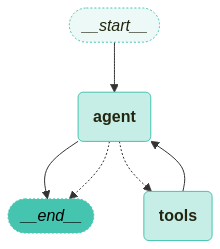

In [15]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [17]:
print(app.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +-------+           
          | agent |           
          +-------+.          
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [18]:
# 실행 및 결과 확인
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_pmpQdmhjHdm6j6b4ChfE3QXQ)
 Call ID: call_pmpQdmhjHdm6j6b4ChfE3QXQ
  Args:
    code: def first_n_primes(n):
    primes = []
    num = 2  # Starting from the first prime number
    while len(primes) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
        num += 1
    return primes

# Get the first 5 prime numbers
first_n_primes(5)
================================= Tool Message =================================
Name: python_code_interpreter

Error: NameError("name 'PythonAstREPLTool' is not defined")
 Please fix your mistakes.
================================== Ai Message ===================

In [19]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "search google news about MCP")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

search google news about MCP
================================== Ai Message ==================================
Tool Calls:
  search_news (call_ks5IrtOO6eXA7yxwe1wgMAJF)
 Call ID: call_ks5IrtOO6eXA7yxwe1wgMAJF
  Args:
    query: MCP
================================= Tool Message =================================
Name: search_news

[{"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxNUkNXc3dxM09fbWRRcjVOU2NzSEEtOUlwdzdnaENnZU1uaDc0LW9LRmtObUpWZ1dDUHRPbXlOQ1RjQkV5clVwUDJsNC1haGhnSGRpWF9sd0tEbzllUEJsaERjd2x1SW1GSm5DYzZfV2NINllmR2gzejRleUpocVNmbDNB0gGWAUFVX3lxTE5uWDlueUVCSTdOY1hORTN3QUs5enprOTF3R1JGRTVIVkNKc045MmZ6YnhwWFNWYTVTa3IyY0RRMlJFY0pRQVUwZlFKTXBoVzh2M2NsNWI5d19QSDRQYnctTGxWb2Z3T2xidlBMVlE1RGtkWFUwSG00aXpUUU83TURqMVk4MjlJSk5HMDlQcDlfM1FyQkY3UQ?oc=5", "content": "트웰브랩스, 영상이해 기능 구현 MCP 서버 출시 - 조선비즈 - Chosun Biz"}, {"url": "https://news.google.com/rss/articles/CBMiX0FVX3lxTE5ha085ZW05S0dISzQ4dFRMU

In [20]:
# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕? 반가워
================================== Ai Message ==================================

안녕하세요! 반가워요. 어떻게 도와드릴까요?


-----
** End of Documents **